In [1]:
from clean_database import DataCleaner

In [2]:
dc = DataCleaner("data")
dc.drop_zero_sales()
dc.drop_null_sales()
dc.convert_date()

df = dc.data

In [9]:
df.head(1)

,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
Date,,,,,,,,,,,,,,,,,,,
2013-01-02,1115.0,3.0,3697.0,1.0,0.0,0,1.0,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,2


- How is the target:

<AxesSubplot:>

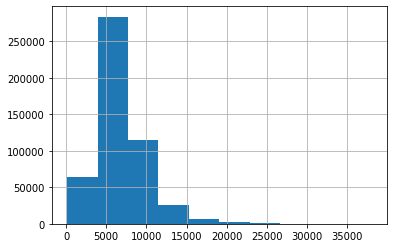

In [11]:
df.Sales.hist()

# Plot Columns

Lets explore the columns one by one:

### Day of week

<AxesSubplot:>

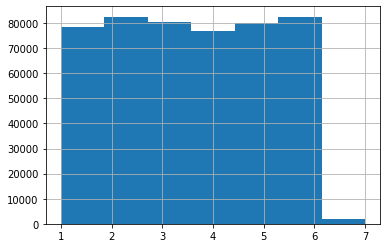

In [10]:
df.DayOfWeek.hist(bins=7)

### Open

<AxesSubplot:>

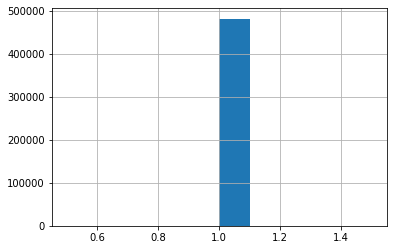

In [12]:
df.Open.hist()

After dropping all zeros from sales, the open column is always 1. We can drop it too!

### Promo

<AxesSubplot:>

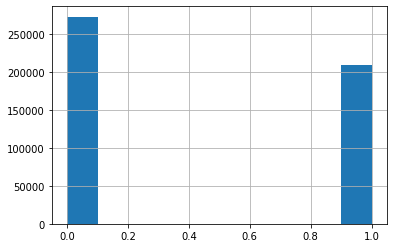

In [16]:
df.Promo.hist()

### State Holiday

<AxesSubplot:>

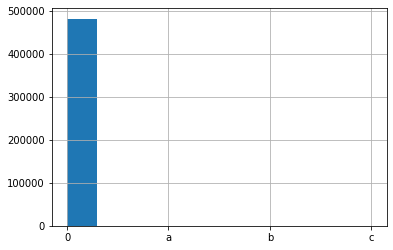

In [17]:
df.StateHoliday.hist()

Seems like this column is zero most of the time!

<AxesSubplot:>

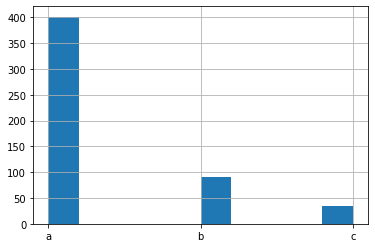

In [21]:
df[df.StateHoliday != "0"].StateHoliday.hist()

### School Holiday

<AxesSubplot:>

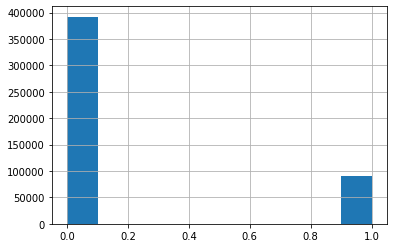

In [22]:
df.SchoolHoliday.hist()

### Store Type

<AxesSubplot:>

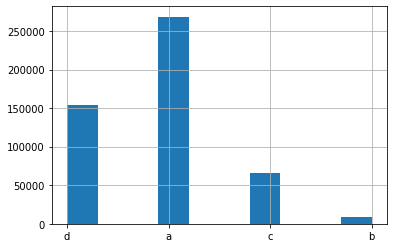

In [23]:
df.StoreType.hist()

### Assortment

<AxesSubplot:>

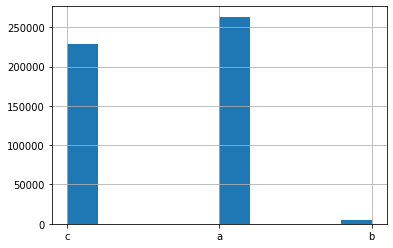

In [24]:
df.Assortment.hist()

### Competition Distance

<AxesSubplot:>

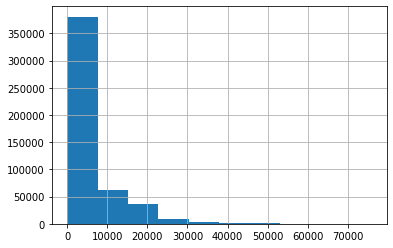

In [25]:
df.CompetitionDistance.hist()

In [28]:
df.CompetitionDistance.min(), df.CompetitionDistance.max()

(20.0, 75860.0)

### Competition Open Since (Month/Year)

array([[<AxesSubplot:title={'center':'CompetitionOpenSinceMonth'}>,
        <AxesSubplot:title={'center':'CompetitionOpenSinceYear'}>]],
      dtype=object)

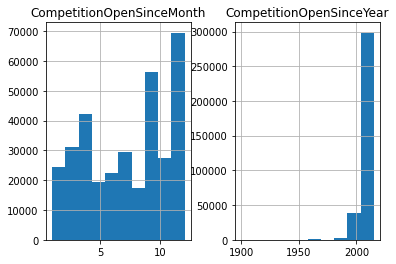

In [33]:
df[["CompetitionOpenSinceMonth","CompetitionOpenSinceYear"]].hist()

In [34]:
df.CompetitionOpenSinceYear.min()

1900.0

### Promo

<AxesSubplot:>

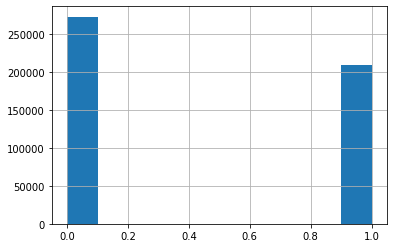

In [35]:
df.Promo.hist()

### Promo2

<AxesSubplot:>

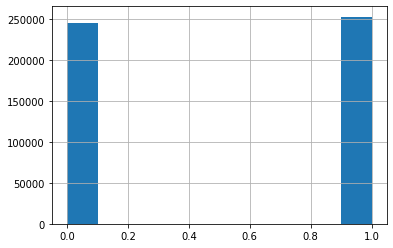

In [36]:
df.Promo2.hist()

### Promo2Since[Year/Month]

array([[<AxesSubplot:title={'center':'Promo2SinceWeek'}>,
        <AxesSubplot:title={'center':'Promo2SinceYear'}>]], dtype=object)

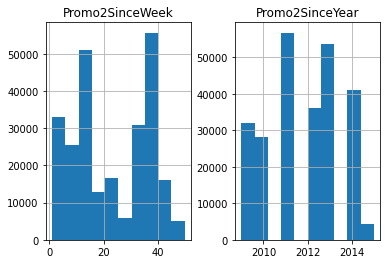

In [38]:
df[["Promo2SinceWeek", "Promo2SinceYear"]].hist()

### Promo Interval

<AxesSubplot:>

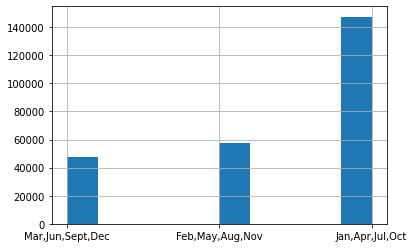

In [39]:
df.PromoInterval.hist()

# Nulls (and possible fill strategies)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 497376 entries, 2013-01-02 to 2014-06-30
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      497376 non-null  float64
 1   DayOfWeek                  482566 non-null  float64
 2   Sales                      497376 non-null  float64
 3   Open                       482366 non-null  float64
 4   Promo                      482364 non-null  float64
 5   StateHoliday               482345 non-null  object 
 6   SchoolHoliday              482283 non-null  float64
 7   StoreType                  497376 non-null  object 
 8   Assortment                 497376 non-null  object 
 9   CompetitionDistance        496071 non-null  float64
 10  CompetitionOpenSinceMonth  339309 non-null  float64
 11  CompetitionOpenSinceYear   339309 non-null  float64
 12  Promo2                     497376 non-null  int64  
 13  Promo2SinceWe

### Day of week

In [42]:
df.DayOfWeek.isnull().sum()

14810

Number of null values is quite low. Despite being a numeric column, taking the most frequent day of week is the most reasonable fill method!

### Open

Got dropped since the store needs to be open, to sell stuff.

### Promo

In [43]:
df.Promo.isnull().sum()

15012

In [48]:
df[df.Promo.isnull()].Promo2.unique()

array([1, 0])

Its probably best to fill the Promo column with the values from Promo2. The reason is that with a continuous promotion running (as indicated by Promo2), they have by definition a promotion running at this day (as indicated by Promo).

### State Holiday

In [56]:
df.StateHoliday.isnull().sum()

15031

One approach might be to use the "holiday" module to fill in holidays where reasonable. But lets just fill with mode (no holiday), for the time being.

### School Holiday

In [68]:
df.SchoolHoliday.isnull().sum()

15093

Same as above ... let just fill with mode.

### Competition Distance

In [69]:
df.CompetitionDistance.isnull().sum()

1305

In [77]:
stores_tmp = df[df.CompetitionDistance.isnull()].Store.unique()

In [78]:
for s in stores_tmp:
    print(f"Store number {s}, misses all entries for CompetitionDistance {df[df.Store == s].CompetitionDistance.isnull().all()}")

Store number 291.0, misses all entries for CompetitionDistance True
Store number 879.0, misses all entries for CompetitionDistance True
Store number 622.0, misses all entries for CompetitionDistance True


We are missing all values, for these three stores.
- Fill with mean, for now.
- We could try to get a more reasonable estimate by getting the mean from stores which are closest in other features (number of customers or similar)

In [79]:
df.CompetitionDistance.mean()

5442.092301303644

### CompetitionOpenSince[Month/Year]

In [87]:
df.CompetitionOpenSinceMonth.isnull().sum(), df.CompetitionOpenSinceYear.isnull().sum()

(158067, 158067)

Lets check if its the same rows that missing the values:

In [86]:
tmp_a = df[df.CompetitionOpenSinceMonth.isnull()].index
tmp_b = df[df.CompetitionOpenSinceYear.isnull()].index
(tmp_a == tmp_b).all()

True

### Promo2

In [88]:
df.Promo2.isnull().sum()

0

### Promo2Since[Week/Year]

In [89]:
df.Promo2SinceWeek.isnull().sum(), df.Promo2SinceYear.isnull().sum()

(244960, 244960)

In [92]:
tmp_a = df[df.Promo2SinceWeek.isnull()].index
tmp_b = df[df.Promo2SinceYear.isnull()].index
(tmp_a == tmp_b).all()

True

In [96]:
(df[df.Promo2SinceWeek.isnull()].Promo2 == 0).all()

True

In absence of a better Idea: mean for year and mode for week...

### Promo Interverval

In [97]:
df.PromoInterval.isnull().sum()

244960